In [1]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
from pathlib import Path
import os
import time
import datetime
import yaml
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import logging

from tqdm.notebook import tqdm

import volpick.model.models as models
import seisbench.models as sbm
import seisbench.generate as sbg
from volpick.model.utils import load_best_model_from_base_dir,load_best_model
import seisbench.data as sbd
from volpick.model.generate_eval_targets import generate_task0, generate_task1, generate_task23

from volpick.model.models import phase_dict
from volpick.model.eval_taks0 import evaluate, get_ground_truth, count_TP_FP_FN, compute_residuals, calculate_precision_recall_F1score, eval_task0, opt_prob_metrics, collect_task0_results,collect_task0_results_dev,opt_prob_metrics_dev
from volpick.model.eval_taks123 import eval_tasks123,collect_task123_results

import json

from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from scipy.stats import rankdata

In [2]:
phase_dict

{'trace_p_arrival_sample': 'P',
 'trace_P_arrival_sample': 'P',
 'trace_s_arrival_sample': 'S',
 'trace_S_arrival_sample': 'S'}

In [3]:
def _identify_instance_dataset_border(task_targets):
    """
    Calculates the dataset border between Signal and Noise for instance,
    assuming it is the only place where the bucket number does not increase
    """
    buckets = task_targets["trace_name"].apply(lambda x: int(x.split("$")[0][6:]))

    last_bucket = 0
    for i, bucket in enumerate(buckets):
        if bucket < last_bucket:
            return i
        last_bucket = bucket

# Load dataset

In [4]:
data_instance = sbd.InstanceCountsCombined(
    sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="full"
)

In [6]:
print(len(data_instance))
print(len(data_instance.dev()))
print(len(data_instance.test()))

1291537
128278
383994


In [30]:
data_instance_ENZ = sbd.InstanceCountsCombined(
    sampling_rate=100, component_order="ENZ", dimension_order="NCW", cache="full"
)

In [8]:
targets_path = Path("/home/zhongyiyuan/volpick/model_training/Eval_targets/instance")
try:
    targets_path.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets/instance exists


In [9]:
[x for x in list(data_instance.metadata.columns) if x.endswith("arrival_sample")]

['trace_P_arrival_sample', 'trace_S_arrival_sample']

In [10]:
replace_if_exist = False
generate_task0(
    dataset=data_instance,
    output=targets_path,
    sampling_rate=100,
    noise_before_events=False,
    keep_source_type=False,
    replace_if_exist=replace_if_exist,
)
generate_task1(
    dataset=data_instance,
    output=targets_path,
    sampling_rate=100,
    noise_before_events=False,
    replace_if_exist=replace_if_exist,
)
generate_task23(
    dataset=data_instance,
    output=targets_path,
    sampling_rate=100,
    replace_if_exist=replace_if_exist,
)

/home/zhongyiyuan/volpick/model_training/Eval_targets/instance/task0.csv" has already existed. No task files will be generated.
/home/zhongyiyuan/volpick/model_training/Eval_targets/instance/task1.csv" has already existed. No task files will be generated.
/home/zhongyiyuan/volpick/model_training/Eval_targets/instance/task23.csv" has already existed. No task files will be generated.


In [ ]:
# split = data_instance.get_split("dev")
# logging.warning("Overwriting noise trace_names to allow correct identification")
# # Replace trace names for noise entries
# split._metadata["trace_name"].values[-len(split.datasets[-1]) :] = split._metadata[
#     "trace_name"
# ][-len(split.datasets[-1]) :].apply(lambda x: "noise_" + x)
# split._build_trace_name_to_idx_dict()

# logging.warning(f"Starting set {'dev'}")
# split.preload_waveforms(pbar=True)

# Load model

In [11]:
vol_eqt = sbm.EQTransformer.from_pretrained("volpick")
vol_eqt.cuda()
vol_pn = sbm.PhaseNet.from_pretrained("volpick")
vol_pn.cuda()
print(vol_eqt.labels)
print(vol_pn.labels)
print(vol_eqt.norm)
print(vol_pn.norm)
print(vol_eqt.device)
print(vol_pn.device)
# org_eqt = sbm.EQTransformer.from_pretrained("original")
org_eqt = sbm.EQTransformer.from_pretrained("original_nonconservative")
org_pn = sbm.PhaseNet.from_pretrained("original")
org_eqt.cuda()
org_pn.cuda()
print(org_eqt.labels)
print(org_pn.labels)
print(org_eqt.norm)
print(org_pn.norm)
print(org_eqt.device)
print(org_pn.device)

eqt_instance = sbm.EQTransformer.from_pretrained("instance")
pn_instance = sbm.PhaseNet.from_pretrained("instance")
eqt_instance.cuda()
pn_instance.cuda()
print(eqt_instance.labels)
print(pn_instance.labels)
print(eqt_instance.norm)
print(pn_instance.norm)
print(eqt_instance.device)
print(pn_instance.device)

['Detection', 'P', 'S']
PSN
peak
peak
cuda:0
cuda:0
['Detection', 'P', 'S']
NPS
std
std
cuda:0
cuda:0
['Detection', 'P', 'S']
PSN
peak
peak
cuda:0
cuda:0


In [32]:
print(org_pn.component_order)

ENZ


# Tune threshold on the validation set

In [33]:
model_dict = {
    "vol_eqt": vol_eqt,
    "vol_pn": vol_pn,
    "org_eqt": org_eqt,
    "org_pn": org_pn,
    "int_eqt": eqt_instance,
    "int_pn": pn_instance,
}

In [13]:
targets_path.name

'instance'

In [34]:
for model_name, model in model_dict.items():
    print(model_name)

vol_eqt
vol_pn
org_eqt
org_pn
int_eqt
int_pn


In [15]:
np.arange(0.01, 0.6, 0.01)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59])

In [36]:
org_pn == model_dict["org_pn"]

True

In [16]:
tp_thre = 0.5
# target_path_list = [targets_path]
# dataset_list = [data_instance]
for model_name, model in model_dict.items():
    if model_name != "org_pn":
        print(model_name)
        eval_task0(
            dev_test_set=data_instance,
            model=model,
            exp_name=model_name,
            targets_path=targets_path,
            root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_INSTANCE",
            prob_thres=np.arange(0.01, 0.61, 0.01),
            num_workers=16,
            batchsize=2048,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["dev"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )
    else:
        eval_task0(
            dev_test_set=data_instance_ENZ,
            model=model,
            exp_name=model_name,
            targets_path=targets_path,
            root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_INSTANCE",
            prob_thres=np.concatenate(
                [np.array([0.001, 0.005, 0.007, 0.008]), np.arange(0.01, 0.61, 0.01)]
            ),
            num_workers=16,
            batchsize=2048,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["dev"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )        

# eval_task0(
#     dev_test_set=data_instance_ENZ,
#     model=org_pn,
#     exp_name="org_pn",
#     targets_path=targets_path,
#     root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_INSTANCE",
#     prob_thres=np.arange(0.01, 0.61, 0.01),
#     num_workers=16,
#     batchsize=2048,
#     num_test_run=-1,
#     output_remark="pred",
#     tp_thre=tp_thre,
#     sets=["dev"],
#     # sets=["train", "dev","test"],
#     # append_to_file=True,
#     data_norm_type=model.norm,
# )

vol_eqt
/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/vol_eqt exists


Starting set: dev


Preloading waveforms: 100%|██████████| 13251/13251 [00:01<00:00, 12048.55it/s]


Number of examples in dev: 128277
115026 earthquake traces
13251 noise traces
Probability threshold: 0.0100
Probability threshold: 0.0200
Probability threshold: 0.0300
Probability threshold: 0.0400
Probability threshold: 0.0500
Probability threshold: 0.0600
Probability threshold: 0.0700
Probability threshold: 0.0800
Probability threshold: 0.0900
Probability threshold: 0.1000
Probability threshold: 0.1100
Probability threshold: 0.1200
Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold:

/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5000


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5100


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5200


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5300


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5400


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5500


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5600


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5700


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5800


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5900


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.6000


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


vol_pn
/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/vol_pn exists


Starting set: dev


Preloading waveforms: 100%|██████████| 13251/13251 [00:01<00:00, 11442.43it/s]


Number of examples in dev: 128277
115026 earthquake traces
13251 noise traces
Probability threshold: 0.0100
Probability threshold: 0.0200
Probability threshold: 0.0300
Probability threshold: 0.0400
Probability threshold: 0.0500
Probability threshold: 0.0600
Probability threshold: 0.0700
Probability threshold: 0.0800
Probability threshold: 0.0900
Probability threshold: 0.1000
Probability threshold: 0.1100
Probability threshold: 0.1200
Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold:

/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5000


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5100


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5200


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5300


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5400


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5500


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5600


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5700


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5800


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5900


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.6000


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


org_eqt
/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/org_eqt exists


Starting set: dev


Preloading waveforms: 100%|██████████| 13251/13251 [00:01<00:00, 13194.84it/s]


Number of examples in dev: 128277
115026 earthquake traces
13251 noise traces
Probability threshold: 0.0100
Probability threshold: 0.0200
Probability threshold: 0.0300
Probability threshold: 0.0400
Probability threshold: 0.0500
Probability threshold: 0.0600
Probability threshold: 0.0700
Probability threshold: 0.0800
Probability threshold: 0.0900
Probability threshold: 0.1000
Probability threshold: 0.1100
Probability threshold: 0.1200
Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold:

/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5000


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5100


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5200


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5300


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5400


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5500


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5600


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5700


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5800


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5900


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.6000


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


int_eqt
/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/int_eqt exists


Starting set: dev


Preloading waveforms: 100%|██████████| 13251/13251 [00:07<00:00, 1738.94it/s]


Number of examples in dev: 128277
115026 earthquake traces
13251 noise traces
Probability threshold: 0.0100
Probability threshold: 0.0200
Probability threshold: 0.0300
Probability threshold: 0.0400
Probability threshold: 0.0500
Probability threshold: 0.0600
Probability threshold: 0.0700
Probability threshold: 0.0800
Probability threshold: 0.0900
Probability threshold: 0.1000
Probability threshold: 0.1100
Probability threshold: 0.1200
Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold:

/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5000


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5100


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5200


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5300


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5400


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5500


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5600


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5700


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5800


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5900


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.6000


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


int_pn
/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/int_pn exists


Starting set: dev


Preloading waveforms: 100%|██████████| 13251/13251 [00:01<00:00, 12256.43it/s]


Number of examples in dev: 128277
115026 earthquake traces
13251 noise traces
Probability threshold: 0.0100
Probability threshold: 0.0200
Probability threshold: 0.0300
Probability threshold: 0.0400
Probability threshold: 0.0500
Probability threshold: 0.0600
Probability threshold: 0.0700
Probability threshold: 0.0800
Probability threshold: 0.0900
Probability threshold: 0.1000
Probability threshold: 0.1100
Probability threshold: 0.1200
Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold:

/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5000


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5100


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5200


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5300


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5400


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5500


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5600


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5700


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5800


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5900


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.6000


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/org_pn exists


Starting set: dev


Preloading waveforms: 100%|██████████| 13251/13251 [00:01<00:00, 13149.48it/s]


Number of examples in dev: 128277
115026 earthquake traces
13251 noise traces
Probability threshold: 0.0100
Probability threshold: 0.0200
Probability threshold: 0.0300
Probability threshold: 0.0400
Probability threshold: 0.0500
Probability threshold: 0.0600
Probability threshold: 0.0700
Probability threshold: 0.0800
Probability threshold: 0.0900
Probability threshold: 0.1000
Probability threshold: 0.1100
Probability threshold: 0.1200
Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold:

/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5000


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5100


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5200


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5300


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5400


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5500


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5600


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5700


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5800


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5900


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.6000


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


In [40]:
for model_name, model in model_dict.items():
    if model_name == "org_pn":
        print(model_name)

org_pn


In [37]:
for model_name, model in model_dict.items():
    if model_name == "org_pn":
        print(model_name)
        eval_task0(
            dev_test_set=data_instance_ENZ,
            model=model,
            exp_name=model_name,
            targets_path=targets_path,
            root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_INSTANCE",
            prob_thres=np.concatenate(
                [np.array([0.001, 0.005, 0.007, 0.008]), np.arange(0.01, 0.61, 0.01)]
            ),
            num_workers=16,
            batchsize=2048,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["dev"],
            # sets=["train", "dev","test"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

org_pn
/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/org_pn exists


Starting set: dev


Preloading waveforms: 100%|██████████| 13251/13251 [00:01<00:00, 9981.99it/s]


Number of examples in dev: 128277
115026 earthquake traces
13251 noise traces
Probability threshold: 0.0010
Probability threshold: 0.0050
Probability threshold: 0.0070
Probability threshold: 0.0080
Probability threshold: 0.0100
Probability threshold: 0.0200
Probability threshold: 0.0300
Probability threshold: 0.0400
Probability threshold: 0.0500
Probability threshold: 0.0600
Probability threshold: 0.0700
Probability threshold: 0.0800
Probability threshold: 0.0900
Probability threshold: 0.1000
Probability threshold: 0.1100
Probability threshold: 0.1200
Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold:

/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.4600


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.4700


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.4800


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.4900


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5000


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5100


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5200


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5300


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5400


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5500


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5600


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5700


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5800


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.5900


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


Probability threshold: 0.6000


/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:524: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"p_pred_sample_thr{prob_thre:.4f}"] = p_idxs_predicted
/home/zhongyiyuan/volpick/volpick/model/eval_taks0.py:525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_targets[f"s_pred_sample_thr{prob_thre:.4f}"] = s_idxs_predicted


In [38]:
model_pred_save_path = Path(
    "/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0"
)
stats_list = []
for pred_dir in model_pred_save_path.iterdir():
    if pred_dir.is_dir():
        print(pred_dir)
        stats = opt_prob_metrics_dev(pred_dir)
        stats_list.append(stats)
df = pd.DataFrame(stats_list)
df.to_csv(model_pred_save_path / "optimal_threshold_dev.csv", index=False)
df

/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/vol_eqt
/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/org_pn0
/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/int_pn
/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/org_eqt
/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/vol_pn
/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/org_pn
/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/int_eqt


,exp_name,tp_thre,p_opt_prob_thre,s_opt_prob_thre,dev_p_TP,dev_p_FP,dev_p_FN,dev_p_precision,dev_p_recall,dev_p_F1score,...,dev_s_modified_std,dev_s_modified_RMSE,dev_s_modified_MAE,dev_s_modified_MAD,dev_s_modified_mean2,dev_s_modified_median2,dev_s_modified_std2,dev_s_modified_RMSE2,dev_s_modified_MAE2,dev_s_modified_MAD2
0,vol_eqt,0.5,0.33,0.46,99066.0,8740.0,15960.0,0.918928,0.861249,0.889154,...,0.236678,0.248357,0.148053,0.08,0.071856,0.04,0.184256,0.197769,0.127562,0.07
1,org_pn0,0.5,0.01,0.01,67608.0,33145.0,47418.0,0.671027,0.587763,0.626641,...,0.340704,0.416674,0.289091,0.12,0.188145,0.14,0.232097,0.298774,0.216526,0.10
2,int_pn,0.5,0.29,0.26,103957.0,6126.0,11069.0,0.944351,0.903770,0.923615,...,0.214370,0.214373,0.123625,0.06,-0.000877,-0.01,0.177237,0.177238,0.110266,0.06
3,org_eqt,0.5,0.24,0.35,84851.0,38190.0,30175.0,0.689616,0.737668,0.712833,...,0.263819,0.277743,0.155034,0.07,0.075396,0.04,0.171523,0.187361,0.116545,0.06
4,vol_pn,0.5,0.41,0.57,96846.0,8865.0,18180.0,0.916139,0.841949,0.877479,...,0.237768,0.244004,0.138092,0.07,0.046001,0.02,0.179864,0.185652,0.115115,0.07
5,org_pn,0.5,0.42,0.49,96302.0,11030.0,18724.0,0.897235,0.837219,0.866189,...,0.283980,0.312722,0.191288,0.07,0.121334,0.08,0.179662,0.216795,0.145756,0.06
6,int_eqt,0.5,0.22,0.24,102804.0,6964.0,12222.0,0.936557,0.893746,0.914651,...,0.228203,0.232639,0.138956,0.08,0.040255,0.03,0.181715,0.186119,0.121223,0.07


In [18]:
for i, exp_name in enumerate(model_dict):
    print(exp_name)

vol_eqt
vol_pn
org_eqt
org_pn
int_eqt
int_pn


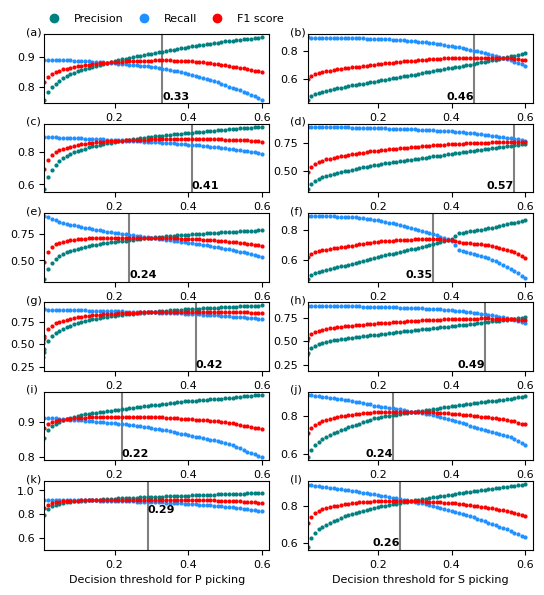

In [43]:
fts = 8
cm = 1 / 2.54
fig, axs = plt.subplots(6, 2, figsize=(16 * cm, 17 * cm))
plt.subplots_adjust(wspace=0.17, hspace=0.30)
colors = ["teal", "dodgerblue", "red"]
metrics_labels = {"precision": "Precision", "recall": "Recall", "F1score": "F1 score"}
ylabels_dict = {
    "EQTransformer_org": "Original EQTransformer",
    "EQTransformer_org_instance": "EQTransformer \ntrained on INSTANCE",
    "PhaseNet_org_instance": "PhaseNet \ntrained on INSTANCE",
    "PhaseNet_org": "Original PhaseNet",
}

for i, exp_name in enumerate(model_dict):
    dev_result = pd.read_csv(
        f"/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/{exp_name}/dev_metrics.csv"
    )
    prob_thre = dev_result["prob_thre"]
    for j, phase in enumerate(["p", "s"]):
        ax = axs[i][j]
        # precision = pn_dev_result[f"{phase}_precision"]
        # recall = pn_dev_result[f"{phase}_recall"]
        # F1score = pn_dev_result[f"{phase}_F1score"]
        # f1score = dev_result[f"{phase}_F1score"]
        f1score = 1 / (
            1 / dev_result[f"{phase}_recall"] + 1 / dev_result[f"{phase}_precision"]
        )
        opt_thre = prob_thre[np.argmax(f1score)]
        ax.axvline(opt_thre, color="grey")
        # print(opt_thre)
        if opt_thre < 0.03:
            print(opt_thre, metric_name, exp_name)
            plot_func = ax.semilogx
        else:
            plot_func = ax.plot
        for k, metric_name in enumerate(["precision", "recall", "F1score"]):
            metric_value = dev_result[f"{phase}_{metric_name}"]
            plot_func(
                prob_thre,
                metric_value,
                color=colors[k],
                label=metrics_labels[metric_name],
                markersize=4,
                marker=".",
                linestyle="",
            )
            ax.tick_params(labelsize=fts)
        ax.text(
            opt_thre,
            # 0.88,
            ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.02,
            f"{opt_thre:.2f}",
            verticalalignment="bottom",
            horizontalalignment=["left", "right"][j],
            # transform=ax.transAxes,
            fontsize=fts,
            weight="bold",
            color="black",
        )
        ax.set_xlim([0.01, 0.62])
        # print(opt_thre)
    # axs[i][0].set_ylabel(ylabels_dict[exp_name], fontsize=fts)
axs[0][0].legend(
    loc="lower left",
    bbox_to_anchor=(-0.05, 1, 0.8, 0.5),
    frameon=False,
    markerscale=3,
    fontsize=fts,
    ncols=3,
    columnspacing=0.8,
)
axs[-1][0].set_ylim([0.5, 1.08])
axs[-1][0].set_xlabel("Decision threshold for P picking", fontsize=fts)
axs[-1][1].set_xlabel("Decision threshold for S picking", fontsize=fts)
for i, ax in enumerate(axs.flat):
    ax.text(
        -0.08,
        1.1,
        "(" + chr(97 + i) + ")",
        verticalalignment="top",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
plt.savefig("threshold_tuning_INSTANCE.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

# Evaluation on the test set

In [44]:
model_pred_save_path = Path(
    "/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0"
)
df = pd.read_csv(model_pred_save_path / "optimal_threshold_dev.csv")

In [45]:
model_dict = {
    "vol_eqt": vol_eqt,
    "vol_pn": vol_pn,
    "org_eqt": org_eqt,
    "org_pn": org_pn,
    "int_eqt": eqt_instance,
    "int_pn": pn_instance,
}

In [46]:
prob_thres_dict = {
    "vol_eqt": np.array([0.33, 0.46]),
    "vol_pn": np.array([0.41, 0.57]),
    "org_eqt": np.array([0.24, 0.35]),
    "org_pn": np.array([0.42, 0.49]),
    "int_eqt": np.array([0.22, 0.24]),
    "int_pn": np.array([0.29, 0.26]),
}

In [48]:
df

,exp_name,tp_thre,p_opt_prob_thre,s_opt_prob_thre,dev_p_TP,dev_p_FP,dev_p_FN,dev_p_precision,dev_p_recall,dev_p_F1score,...,dev_s_modified_std,dev_s_modified_RMSE,dev_s_modified_MAE,dev_s_modified_MAD,dev_s_modified_mean2,dev_s_modified_median2,dev_s_modified_std2,dev_s_modified_RMSE2,dev_s_modified_MAE2,dev_s_modified_MAD2
0,vol_eqt,0.5,0.33,0.46,99066.0,8740.0,15960.0,0.918928,0.861249,0.889154,...,0.236678,0.248357,0.148053,0.08,0.071856,0.04,0.184256,0.197769,0.127562,0.07
1,org_pn0,0.5,0.01,0.01,67608.0,33145.0,47418.0,0.671027,0.587763,0.626641,...,0.340704,0.416674,0.289091,0.12,0.188145,0.14,0.232097,0.298774,0.216526,0.10
2,int_pn,0.5,0.29,0.26,103957.0,6126.0,11069.0,0.944351,0.903770,0.923615,...,0.214370,0.214373,0.123625,0.06,-0.000877,-0.01,0.177237,0.177238,0.110266,0.06
3,org_eqt,0.5,0.24,0.35,84851.0,38190.0,30175.0,0.689616,0.737668,0.712833,...,0.263819,0.277743,0.155034,0.07,0.075396,0.04,0.171523,0.187361,0.116545,0.06
4,vol_pn,0.5,0.41,0.57,96846.0,8865.0,18180.0,0.916139,0.841949,0.877479,...,0.237768,0.244004,0.138092,0.07,0.046001,0.02,0.179864,0.185652,0.115115,0.07
5,org_pn,0.5,0.42,0.49,96302.0,11030.0,18724.0,0.897235,0.837219,0.866189,...,0.283980,0.312722,0.191288,0.07,0.121334,0.08,0.179662,0.216795,0.145756,0.06
6,int_eqt,0.5,0.22,0.24,102804.0,6964.0,12222.0,0.936557,0.893746,0.914651,...,0.228203,0.232639,0.138956,0.08,0.040255,0.03,0.181715,0.186119,0.121223,0.07


In [47]:
targets_path

PosixPath('/home/zhongyiyuan/volpick/model_training/Eval_targets/instance')

In [49]:
tp_thre = 0.5
for model_name, model in model_dict.items():
    print(model_name)
    eval_task0(
        dev_test_set=data_instance,
        model=model,
        exp_name=model_name,
        targets_path=targets_path,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Test_INSTANCE",
        prob_thres=prob_thres_dict[model_name],
        num_workers=16,
        batchsize=2048,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["test"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )
    # eval_task0(
    #     dev_test_set=data_instance,
    #     model=model,
    #     exp_name=model_name,
    #     targets_path=targets_path,
    #     root_save_dir="/home/zhongyiyuan/volpick/model_training/Noise_specificity",
    #     # prob_thres=np.array([0.27,0.3,0.32]),
    #     # prob_thres=np.array([0.21,0.22,0.23,0.24,0.25,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35]), #,0.24,0.245,0.25,0.255,0.26,0.265,0.27,0.28,0.29,0.3
    #     prob_thres=prob_thres_dict[model_name],
    #     num_workers=32,
    #     batchsize=1024,
    #     num_test_run=-1,
    #     output_remark="pred",
    #     sets=["test"],
    #     # sets=["test"],
    #     data_norm_type=model.norm,
    # )

vol_eqt
/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/vol_eqt exists


Starting set: test


Preloading waveforms: 100%|██████████| 39752/39752 [00:24<00:00, 1596.01it/s]


Number of examples in test: 383994
344242 earthquake traces
39752 noise traces
Probability threshold: 0.3300
Probability threshold: 0.4600
vol_pn
/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/vol_pn exists


Starting set: test


Preloading waveforms: 100%|██████████| 39752/39752 [00:24<00:00, 1601.19it/s]


Number of examples in test: 383994
344242 earthquake traces
39752 noise traces
Probability threshold: 0.4100
Probability threshold: 0.5700
org_eqt
/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/org_eqt exists


Starting set: test


Preloading waveforms: 100%|██████████| 39752/39752 [00:24<00:00, 1652.99it/s]


Number of examples in test: 383994
344242 earthquake traces
39752 noise traces
Probability threshold: 0.2400
Probability threshold: 0.3500
org_pn
/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/org_pn exists


Starting set: test


Preloading waveforms: 100%|██████████| 39752/39752 [00:05<00:00, 7210.82it/s] 


Number of examples in test: 383994
344242 earthquake traces
39752 noise traces
Probability threshold: 0.4200
Probability threshold: 0.4900
int_eqt
/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/int_eqt exists


Starting set: test


Preloading waveforms: 100%|██████████| 39752/39752 [00:23<00:00, 1657.95it/s]


Number of examples in test: 383994
344242 earthquake traces
39752 noise traces
Probability threshold: 0.2200
Probability threshold: 0.2400
int_pn
/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/instance_pred/task0/int_pn exists


Starting set: test


Preloading waveforms: 100%|██████████| 39752/39752 [00:10<00:00, 3893.34it/s]


Number of examples in test: 383994
344242 earthquake traces
39752 noise traces
Probability threshold: 0.2900
Probability threshold: 0.2600


# Plot

In [60]:
df

,exp_name,tp_thre,p_opt_prob_thre,s_opt_prob_thre,dev_p_TP,dev_p_FP,dev_p_FN,dev_p_precision,dev_p_recall,dev_p_F1score,...,dev_s_modified_std,dev_s_modified_RMSE,dev_s_modified_MAE,dev_s_modified_MAD,dev_s_modified_mean2,dev_s_modified_median2,dev_s_modified_std2,dev_s_modified_RMSE2,dev_s_modified_MAE2,dev_s_modified_MAD2
0,vol_eqt,0.5,0.33,0.46,99066.0,8740.0,15960.0,0.918928,0.861249,0.889154,...,0.236678,0.248357,0.148053,0.08,0.071856,0.04,0.184256,0.197769,0.127562,0.07
1,org_pn0,0.5,0.01,0.01,67608.0,33145.0,47418.0,0.671027,0.587763,0.626641,...,0.340704,0.416674,0.289091,0.12,0.188145,0.14,0.232097,0.298774,0.216526,0.10
2,int_pn,0.5,0.29,0.26,103957.0,6126.0,11069.0,0.944351,0.903770,0.923615,...,0.214370,0.214373,0.123625,0.06,-0.000877,-0.01,0.177237,0.177238,0.110266,0.06
3,org_eqt,0.5,0.24,0.35,84851.0,38190.0,30175.0,0.689616,0.737668,0.712833,...,0.263819,0.277743,0.155034,0.07,0.075396,0.04,0.171523,0.187361,0.116545,0.06
4,vol_pn,0.5,0.41,0.57,96846.0,8865.0,18180.0,0.916139,0.841949,0.877479,...,0.237768,0.244004,0.138092,0.07,0.046001,0.02,0.179864,0.185652,0.115115,0.07
5,org_pn,0.5,0.42,0.49,96302.0,11030.0,18724.0,0.897235,0.837219,0.866189,...,0.283980,0.312722,0.191288,0.07,0.121334,0.08,0.179662,0.216795,0.145756,0.06
6,int_eqt,0.5,0.22,0.24,102804.0,6964.0,12222.0,0.936557,0.893746,0.914651,...,0.228203,0.232639,0.138956,0.08,0.040255,0.03,0.181715,0.186119,0.121223,0.07


In [61]:
p_thre_dict = {
    "vol_eqt": 0.33,
    "vol_pn": 0.41,
    "org_eqt": 0.24,
    "org_pn": 0.42,
    "int_eqt": 0.22,
    "int_pn": 0.29,
}

s_thre_dict = {
    "vol_eqt": 0.46,
    "vol_pn": 0.57,
    "org_eqt": 0.35,
    "org_pn": 0.49,
    "int_eqt": 0.24,
    "int_pn": 0.26,
}

In [62]:
pred_dirs = ["org_pn", "org_eqt", "int_pn", "int_eqt", "vol_pn", "vol_eqt"]
# data_types_plotted = [
#     "ncedc_vt_pred",
#     "ncedc_lp_pred",
# ]  # ['rg_and_noise_pred','lp_and_noise_pred']
precision_dict = {x: [] for x in pred_dirs}
recall_dict = {x: [] for x in pred_dirs}
f1score_dict = {x: [] for x in pred_dirs}
pred_dir_path = Path("/home/zhongyiyuan/volpick/model_training/Test_INSTANCE/")

for model_name in pred_dirs:
    # for j, data_type in enumerate(data_types_plotted):
    pred_df = pd.read_csv(
        pred_dir_path / "instance_pred" / "task0" / model_name / "test_metrics.csv"
    )
    p_row = pred_df[np.isclose(pred_df["prob_thre"], p_thre_dict[model_name])].iloc[0]
    s_row = pred_df[np.isclose(pred_df["prob_thre"], s_thre_dict[model_name])].iloc[0]
    assert (
        np.abs(p_row["prob_thre"] - p_thre_dict[model_name]) < 1e-6
    ), f"{p_row['prob_thre']}, {p_thre_dict[model_name]}"
    assert np.abs(s_row["prob_thre"] - s_thre_dict[model_name]) < 1e-6

    precision_dict[model_name] = [p_row["p_precision"], s_row["s_precision"]]
    recall_dict[model_name] = [p_row["p_recall"], s_row["s_recall"]]
    f1score_dict[model_name] = [p_row["p_F1score"], s_row["s_F1score"]]

metrics = {"Recall": recall_dict, "Precision": precision_dict, "F1 score": f1score_dict}

In [63]:
metrics

{'Recall': {'org_pn': [0.7623503233190604, 0.7275202894299404],
  'org_eqt': [0.7372720353704662, 0.7696880805710374],
  'int_pn': [0.901914931937416, 0.8334751148919527],
  'int_eqt': [0.892581381702407, 0.8380756820181872],
  'vol_pn': [0.8405598387181111, 0.7803461425638017],
  'vol_eqt': [0.8592879427844365, 0.7994035396499463]},
 'Precision': {'org_pn': [0.8770364973749026, 0.7001858604870015],
  'org_eqt': [0.687458354325462, 0.7037262194249749],
  'int_pn': [0.9431171647888992, 0.812129613750262],
  'int_eqt': [0.9353517949717048, 0.7983903645433078],
  'vol_pn': [0.9153822792498671, 0.7229229981837699],
  'vol_eqt': [0.9173807463644738, 0.7034261426211453]},
 'F1 score': {'org_pn': [0.8156818743404889, 0.7135914066152758],
  'org_eqt': [0.7114943624304063, 0.735230658584198],
  'int_pn': [0.9220559956640856, 0.822663925724323],
  'int_eqt': [0.9134662122088226, 0.8177518264889193],
  'vol_pn': [0.8763769296702032, 0.7505378214879375],
  'vol_eqt': [0.8873845969235846, 0.7483500

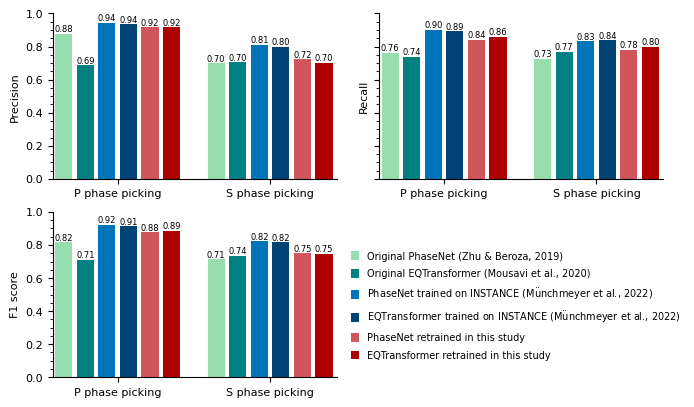

In [66]:
cm = 1 / 2.54
fig, axs = plt.subplots(
    2, 2, figsize=(20 * cm, 12 * cm), sharey="all", squeeze=False
)  # ,layout="constrained"
plt.subplots_adjust(hspace=0.2, wspace=0.15)

data_types = ("P phase picking", "S phase picking")
x = np.arange(len(data_types)) * 2.3
# x=np.array([0,1.5,3])
width = 0.26  # the width of the bars

metric_names = ["Precision", "Recall", "F1 score"]
colors = [
    (164 / 255, 208 / 255, 80 / 255),
    (84 / 255, 130 / 255, 53 / 255),
    (0 / 255, 176 / 255, 240 / 255),
    (0 / 255, 112 / 255, 192 / 255),
    (255 / 255, 192 / 255, 0 / 255),
    (170 / 255, 80 / 255, 30 / 255),
    # (9 / 255, 80 / 255, 153 / 255),
    # (0 / 255, 112 / 255, 182 / 255),
]
# colors = ["#96DEAE", "#008080", "#0074B7", "#003B73", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#880C25"]
colors = ["#96DEAE", "#008080", "#0074B7", "#024376", "#D0565C", "#AE0000"]
# colors = ["#6988E7", "#F05C79", "#0074B7", "#DC143C", "#003B73", "#5E091A"]
# colors=["teal","teal","darkblue","darkblue","purple","purple"]
hatches = ["//", ".", "//", ".", "//", "."]
alphas = [0.7, 1, 0.7, 1, 0.7, 1]
# colors=["aquamarine","dodgerblue","orchid","teal","navy","brown"]
# colors = plt.cm.Paired(np.linspace(0, 1, len(metric_names)))
labels = {
    "org_eqt": "Original EQTransformer (Mousavi et al., 2020)",
    "int_eqt": r"EQTransformer trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_eqt": "EQTransformer retrained in this study",
    "org_pn": "Original PhaseNet (Zhu & Beroza, 2019)",
    "int_pn": r"PhaseNet trained on INSTANCE (M$\rm{\"u}$nchmeyer et al., 2022)",
    "vol_pn": "PhaseNet retrained in this study",
}
# test_set_names = [
#     "Alaska, Hawaii and Japan",
#     "Northern California",
#     "Japan tectonic LPs",
# ]

fts = 8
for i in range(3):
    # for j in range(2):
    # if i == 2 and j == 1:
    #     break
    # if i == 2 and j == 0:
    #     metric_dict = metrics_list[i][metric_names[0]][j]
    #     ax = axs[i][1]
    # else:
    metric_dict = metrics[metric_names[i]]
    ax = axs.flat[i]

    # ax = axs[i][j]

    fmt = "{:.2f}"
    interval = width + 0.065
    for k, (attribute, value) in enumerate(metric_dict.items()):
        offset = interval * k
        rects = ax.bar(
            x + offset,
            value,
            width,
            label=labels[attribute],
            # edgecolor="white",
            color=colors[k],
            # linewidth=3,
        )  # ,edgecolor="black",hatch=hatches[k]
        ax.bar_label(rects, padding=0, fmt=fmt, fontsize=fts - 2.0, color="black")
        ax.spines[["right", "top"]].set_visible(False)

    ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts)
    ax.tick_params(labelsize=fts)
    ax.set_ylim([0.0, 1])
    ax.set_xlim(x[0] - 0.5 * interval, x[-1] + 5.6 * interval)
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.set_ylabel(f"{metric_names[i]}", fontsize=fts)
    # axs[i][0].set_ylabel(metric_names[i], fontsize=fts)
    # axs[0][0].set_ylabel(test_set_names[i], fontsize=fts)
    # axs[0][0].text(
    #     0.02,
    #     1.0,
    #     chr(65 + i),
    #     verticalalignment="top",
    #     horizontalalignment="left",
    #     weight="bold",
    #     transform=axs[0][0].transAxes,
    #     fontsize=fts + 3,
    # )
fig.delaxes(axs[1][1])
handles, legend_labels = axs[1][1].get_legend_handles_labels()

legend_label_order = [0, 2, 4, 1, 3, 5]
# ax.set_xticks(x + 2.5 * interval, data_types, fontsize=fts)
leg = axs[1][0].legend(
    # [handles[idx] for idx in legend_label_order],
    # [legend_labels[idx] for idx in legend_label_order],
    markerfirst=True,
    handlelength=0.8,
    handleheight=1.0,
    #   markerscale=5,
    loc="lower left",
    bbox_to_anchor=(1.02, 0.05, 1, 1.5),
    frameon=False,
    fontsize=fts - 1,
    # ncols=2,
    # columnspacing=0.8,
    labelspacing=0.8,
)

# axs[0][1].set_title("VT test set", fontsize=fts)
# axs[0][0].set_title("LP test set", fontsize=fts)
plt.savefig("peformance_for_INSTANCE.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

In [134]:
2 / (1 / 0.72 + 1 / 0.78)

0.7488

# Debug

In [20]:
split = data_instance.get_split("dev")
if targets_path.name == "instance":
    logging.warning("Overwriting noise trace_names to allow correct identification")
    # Replace trace names for noise entries
    split._metadata["trace_name"].values[-len(split.datasets[-1]) :] = split._metadata[
        "trace_name"
    ][-len(split.datasets[-1]) :].apply(lambda x: "noise_" + x)
    split._build_trace_name_to_idx_dict()

# print(f"Starting set: {eval_set}")
split.preload_waveforms(pbar=True)

# steered metatdata
task_csv = targets_path / "task0.csv"
task_targets = pd.read_csv(task_csv)
task_targets = task_targets[task_targets["trace_split"] == "dev"]
if targets_path.name == "instance":
    border = _identify_instance_dataset_border(task_targets)
    task_targets["trace_name"].values[border:] = task_targets["trace_name"][
        border:
    ].apply(lambda x: "noise_" + x)

# if num_test_run > 0:
#     subset_idxs = np.sort(
#         np.random.default_rng(seed=100).choice(
#             len(task_targets), num_test_run, replace=False
#         )
#     )  # sort inplace
#     task_targets = task_targets.iloc[subset_idxs]

generator = sbg.SteeredGenerator(split, task_targets)

Preloading waveforms: 100%|██████████| 13251/13251 [00:00<00:00, 326752.99it/s]


In [34]:
for i in range(128278):
    y = [x for x in generator.dataset.get_sample(i)[1] if x.endswith("arrival_sample")]
    if len(y) == 0:
        print(i)
        print(generator.dataset.get_sample(i)[1])
        break

115027
{'index': 2, 'source_id': '20050110T014724', 'station_network_code': 'MN', 'station_code': 'CUC', 'station_location_code': nan, 'station_channels': 'HH', 'station_latitude_deg': 39.9938, 'station_longitude_deg': 15.8155, 'station_elevation_m': 637.0, 'station_vs_30_mps': 807.0, 'station_vs_30_detail': 'Vs30 extracted from ShakeMap', 'trace_start_time': '2005-01-10T01:47:23.898867Z', 'trace_dt_s': 0.01, 'trace_npts': 12000, 'trace_E_median_counts': 65.0, 'trace_N_median_counts': -15.0, 'trace_Z_median_counts': -4.0, 'trace_E_mean_counts': -0.13833, 'trace_N_mean_counts': 0.04825, 'trace_Z_mean_counts': 0.0365, 'trace_E_min_counts': -829.0, 'trace_N_min_counts': -380.0, 'trace_Z_min_counts': -208.0, 'trace_E_max_counts': 385.0, 'trace_N_max_counts': 333.0, 'trace_Z_max_counts': 311.0, 'trace_E_rms_counts': 215.034, 'trace_N_rms_counts': 125.291, 'trace_Z_rms_counts': 55.85, 'trace_E_lower_quartile_counts': -99.0, 'trace_N_lower_quartile_counts': -90.0, 'trace_Z_lower_quartile_coun

In [36]:
x = np.nan

In [38]:
if np.isnan(x):
    print("x")

x


In [35]:
"index" in generator.dataset.get_sample(i)[1]

True

In [31]:
len(generator.dataset)

128278

In [27]:
generator.dataset.get_sample(115027)

(array([[ -80,  -80,  -80, ...,   32,   33,   34],
        [ 209,  209,  204, ...,  198,  196,  196],
        [ 384,  385,  383, ..., -102, -102, -104]], dtype=int32),
 {'index': 2,
  'source_id': '20050110T014724',
  'station_network_code': 'MN',
  'station_code': 'CUC',
  'station_location_code': nan,
  'station_channels': 'HH',
  'station_latitude_deg': 39.9938,
  'station_longitude_deg': 15.8155,
  'station_elevation_m': 637.0,
  'station_vs_30_mps': 807.0,
  'station_vs_30_detail': 'Vs30 extracted from ShakeMap',
  'trace_start_time': '2005-01-10T01:47:23.898867Z',
  'trace_dt_s': 0.01,
  'trace_npts': 12000,
  'trace_E_median_counts': 65.0,
  'trace_N_median_counts': -15.0,
  'trace_Z_median_counts': -4.0,
  'trace_E_mean_counts': -0.13833,
  'trace_N_mean_counts': 0.04825,
  'trace_Z_mean_counts': 0.0365,
  'trace_E_min_counts': -829.0,
  'trace_N_min_counts': -380.0,
  'trace_Z_min_counts': -208.0,
  'trace_E_max_counts': 385.0,
  'trace_N_max_counts': 333.0,
  'trace_Z_max_cou

In [25]:
len(data_instance["trace_P_arrival_sample"])

1291537